# EXAMPLES for roundabout_simplification enhancement
10 Aug 2022

In [50]:
import geopandas as gpd
import momepy as mm
import pandas as pd
import pygeos
from shapely.geometry import LineString, Point
from shapely.ops import polygonize

<AxesSubplot:>

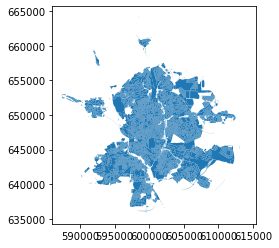

In [2]:
# loading data from file
mad = gpd.read_file(
    "/Users/gregoriomaya/Desktop/GSoc_2022/gsoc2022_network_simpl/data/madrid2062.gpkg"
)
mad.set_index(["u", "v", "key"], inplace=True)


mad_polys = polygonize(mad.geometry)
mad_polys = gpd.GeoDataFrame(geometry=[g for g in mad_polys], crs=mad.crs)
mad_polys.plot()

## loading the needed functions
to replicate what happens in the final **_roundabout_simplification()_**

In [48]:
# for testing purposes only
GPD_10 = True


def _selecting_rabs_from_poly(
    gdf, circom_threshold=0.7, area_threshold=0.85, include_adjacent=True
):
    """
    From a GeoDataFrame of polygons, returns a GDF of polygons that are
    above the Circular Compaactness threshold.

    Return
    ________
    GeoDataFrames : round abouts and adjacent polygons
    """
    # calculate parameters
    gdf = gdf.copy()
    gdf["area"] = gdf.geometry.area
    gdf["circom"] = mm.CircularCompactness(gdf, "area").series

    # selecting round about polygons based on compactness
    rab = gdf[gdf.circom > circom_threshold]
    # exclude those above the area threshold
    area_threshold_val = gdf.area.quantile(area_threshold)
    rab = rab[rab.area < area_threshold_val]

    if include_adjacent is True:
        # calculating some parameters
        bounds = rab.geometry.bounds
        rab = pd.concat([rab, bounds], axis=1)
        rab["deltax"] = rab.maxx - rab.minx
        rab["deltay"] = rab.maxy - rab.miny
        rab["rab_diameter"] = rab[["deltax", "deltay"]].max(axis=1)

        # selecting the adjacent areas that are of smaller than itself
        if GPD_10:
            rab_adj = gpd.sjoin(gdf, rab, predicate="intersects")
        else:
            rab_adj = gpd.sjoin(gdf, rab, op="intersects")
        rab_adj = rab_adj[rab_adj.area_right >= rab_adj.area_left]
        rab_adj.index.name = "index"
        rab_adj["hdist"] = 0

        # adding a hausdorff_distance threshold
        # TODO: (should be a way to verctorize)
        for i, group in rab_adj.groupby("index_right"):
            for g in group.itertuples():
                hdist = g.geometry.hausdorff_distance(rab.loc[i].geometry)
                rab_adj.hdist.loc[g.Index] = hdist

        rab_plus = rab_adj[rab_adj.hdist < rab_adj.rab_diameter]

    else:
        rab["index_right"] = rab.index
        rab_plus = rab

    # only keeping relevant fields
    geom_col = rab_plus.geometry.name
    rab_plus = rab_plus[[geom_col, "index_right"]]

    return rab_plus


def _rabs_center_points(gdf, center_type="centroid"):
    """
    From a selection of roundabouts, returns an aggregated GeoDataFrame
    per round about with extra column with center_type.
    """
    # creating a multipolygon per RAB (as opposed to dissolving) of the entire
    # composition of the RAB
    # temporary DataFrame where geometry is the array of pygeos geometries
    tmp = pd.DataFrame(gdf.copy())  # temporary hack until shapely 2.0 is out
    tmp["geometry"] = tmp.geometry.values.data

    pygeos_geoms = (
        tmp.groupby("index_right")
        .geometry.apply(pygeos.multipolygons)
        .rename("geometry")
    )
    pygeos_geoms = pygeos.make_valid(pygeos_geoms)

    rab_multipolygons = gpd.GeoDataFrame(pygeos_geoms, crs=gdf.crs)
    # make_valid is transforming the multipolygons into geometry collections because of
    # shared edges

    if center_type == "centroid":
        # geometry centroid of the actual circle
        rab_multipolygons["center_pt"] = gdf[
            gdf.index == gdf.index_right
        ].geometry.centroid

    elif center_type == "mean":
        coords, idxs = pygeos.get_coordinates(pygeos_geoms, return_index=True)
        means = {}
        for i in np.unique(idxs):
            tmps = coords[idxs == i]
            target_idx = rab_multipolygons.index[i]
            means[target_idx] = Point(tmps.mean(axis=0))

        rab_multipolygons["center_pt"] = gpd.GeoSeries(means, crs=gdf.crs)

    # centerpoint of minimum_bounding_circle
    # minimun_bounding_circle() should be available in Shapely 2.0. Implementation still
    # pending.
    # current environment has 1.8.2

    return rab_multipolygons

# replicating the COINS output mismatch 

In [69]:
selected_rabs = _selecting_rabs_from_poly(mad_polys, include_adjacent=False)
selected_rabs_center = _rabs_center_points(selected_rabs)

In [80]:
# renaming to use the built-in names of the unpacked function
edges = mad.copy()

rab_idx = [33, 3407]
rab_multipolygons = selected_rabs_center.loc[rab_idx]  # isolating for testing

angle_threshold = 0 # to use later in COINS

In [71]:
# REPLICANTING WHAT HAPPENS ON _selecting_incoming_lines
# =======================================================

# selecting the lines that are touching but not covered by
if GPD_10:
    touching = gpd.sjoin(edges, rab_multipolygons, predicate="touches")
else:
    touching = gpd.sjoin(edges, rab_multipolygons, op="touches")

if GPD_10:
    idx_drop = gpd.sjoin(edges, rab_multipolygons, predicate="covered_by").index
else:
    idx_drop = gpd.sjoin(edges, rab_multipolygons, op="covered_by").index

touching_idx = touching.index
ls = list(set(touching_idx) - set(idx_drop))

incoming = touching.loc[ls]

# figuring out which ends of incoming edges needs to be connected to the center_pt
incoming["first_pt"] = incoming.geometry.apply(lambda x: Point(x.coords[0]))
incoming["dist_fisrt_pt"] = incoming.center_pt.distance(incoming.first_pt)
incoming["last_pt"] = incoming.geometry.apply(lambda x: Point(x.coords[-1]))
incoming["dist_last_pt"] = incoming.center_pt.distance(incoming.last_pt)
lines = []
for i, row in incoming.iterrows():
    if row.dist_fisrt_pt < row.dist_last_pt:
        lines.append(LineString([row.first_pt, row.center_pt]))
    else:
        lines.append(LineString([row.last_pt, row.center_pt]))
incoming["line"] = gpd.GeoSeries(lines, index=incoming.index, crs=edges.crs)

# checking in there are more than one incoming lines arriving to the same point
# which would create several new lines
incoming["line_wkt"] = incoming.line.to_wkt()
grouped_lines = incoming.groupby(["line_wkt"])["line_wkt"]
count_s = grouped_lines.count()

# separating the incoming roads that come on their own to those that come in groups
filter_count_one = pd.DataFrame(count_s[count_s == 1])
filter_count_many = pd.DataFrame(count_s[count_s > 1])
incoming_ones = pd.merge(
    incoming, filter_count_one, left_on="line_wkt", right_index=True, how="inner"
)
incoming_many = pd.merge(
    incoming, filter_count_many, left_on="line_wkt", right_index=True, how="inner"
)

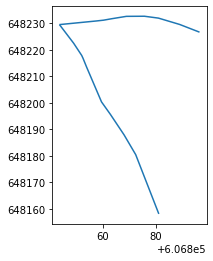

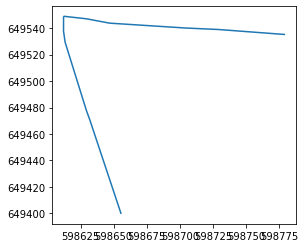

In [77]:
for i in rab_idx:
    incoming_many[incoming_many.index_right == i].plot()

AxesSubplot(0.247519,0.125;0.529963x0.755)
              n_segments                                           geometry
stroke_group                                                               
0                      6  LINESTRING (598655.610 649399.637, 598631.904 ...
1                      5  LINESTRING (598612.131 649548.935, 598629.511 ...
u         v         key
26413145  26413364  0      0
          98944239  0      1
          26413364  0      0
dtype: int64
AxesSubplot(0.24364,0.125;0.537719x0.755)
              n_segments                                           geometry
stroke_group                                                               
0                      8  LINESTRING (606843.606 648229.440, 606857.394 ...
1                     11  LINESTRING (606881.022 648158.157, 606872.315 ...
u         v         key
20952931  20952942  0      1
20952929  20952942  0      1
20952931  20952942  0      1
dtype: int64


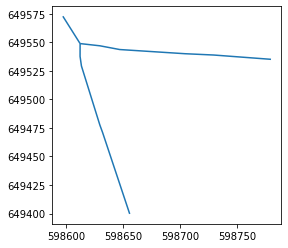

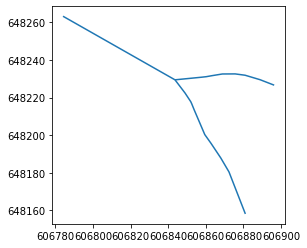

In [94]:
# REPLICANTING WHAT HAPPENS ON _coins_filtering_many_incoming
# =======================================================

coins_filter_result = []
# For each new connection, evaluate COINS and select the group from which the new
# line belongs
# TODO ideally use the groupby object on line_wkt used earlier
for g, x in incoming_many.groupby("line_wkt"):
    gs = gpd.GeoSeries(pd.concat([x.geometry, x.line]), crs=incoming_many.crs)
    gdf = gpd.GeoDataFrame(geometry=gs)
    gdf.drop_duplicates(inplace=True)
    
    #visualize the output for testing
    print(gdf.plot())
    
    coins = mm.COINS(gdf, angle_threshold=angle_threshold)
    stroke_gdf = coins.stroke_gdf()
    print(stroke_gdf)
    
    # the groups here don't match the stroke_group in stroke_gdf
    print(coins.stroke_attribute()) 